In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=5000) # just read first 5000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(73641, 4)

In [8]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [9]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [10]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [11]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
inter_dim = 32
final_dim = 16
latent_dim = 4
input_dim = 4

In [13]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim, activation='relu')(x)
h2 = Dense(final_dim, activation='relu')(h1)
z_mean = Dense(latent_dim)(h2)
z_log_sigma = Dense(latent_dim)(h2)

In [14]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [15]:
# decoder
decoder_h2 = Dense(final_dim, activation='relu')
decoder_h1 = Dense(inter_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h2_decoded = decoder_h2(z)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [16]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [17]:
mse = keras.losses.MeanSquaredError()
def vae_loss(x, y):
    mse_loss = mse(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [18]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           528         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            68          dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
batch_size = 200
epochs = 100

In [21]:
x_train.shape

(58912, 4)

In [22]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val))

Train on 58912 samples, validate on 7364 samples
Epoch 1/100
58912/58912 [==============================] - 2s 38us/step - loss: 0.9229 - val_loss: 0.7430
Epoch 2/100
58912/58912 [==============================] - 2s 26us/step - loss: 0.7035 - val_loss: 0.6672
Epoch 3/100
58912/58912 [==============================] - 2s 26us/step - loss: 0.6595 - val_loss: 0.6523
Epoch 4/100
58912/58912 [==============================] - 2s 26us/step - loss: 0.6447 - val_loss: 0.6384
Epoch 5/100
58912/58912 [==============================] - 2s 27us/step - loss: 0.6400 - val_loss: 0.6360
Epoch 6/100
58912/58912 [==============================] - 2s 27us/step - loss: 0.6361 - val_loss: 0.6318
Epoch 7/100
58912/58912 [==============================] - 2s 27us/step - loss: 0.6293 - val_loss: 0.6256
Epoch 8/100
58912/58912 [==============================] - 2s 27us/step - loss: 0.6305 - val_loss: 0.6264
Epoch 9/100
58912/58912 [==============================] - 2s 26us/step - loss: 0.6277 - val_loss: 0.62

58912/58912 [==============================] - 1s 24us/step - loss: 0.6041 - val_loss: 0.6040
Epoch 78/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6037 - val_loss: 0.5985
Epoch 79/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6035 - val_loss: 0.5971
Epoch 80/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6050 - val_loss: 0.6018
Epoch 81/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6024 - val_loss: 0.5985
Epoch 82/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6025 - val_loss: 0.6093
Epoch 83/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6040 - val_loss: 0.5994
Epoch 84/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6032 - val_loss: 0.6015
Epoch 85/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6062 - val_loss: 0.6025
Epoch 86/100
58912/58912 [========================

# Visualization

In [23]:
import matplotlib.pyplot as plt

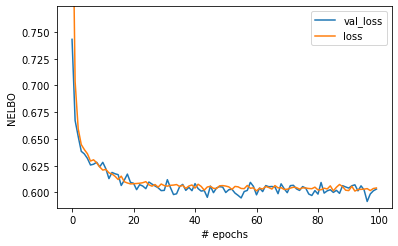

In [24]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [25]:
predictions = vae.predict(x_test)

In [26]:
predictions

array([[-0.31860852, -0.2217254 , -0.8620342 , -0.2610172 ],
       [-0.3502915 ,  1.0951138 , -0.41847637, -0.2845958 ],
       [-0.41989505,  1.2177718 ,  0.7398839 , -0.30688342],
       ...,
       [-0.3566109 , -0.6563587 , -0.21193004, -0.2824178 ],
       [-0.39668548, -0.9366727 , -0.49533254, -0.3143061 ],
       [-0.3707764 , -0.62992084,  0.7199376 , -0.28598222]],
      dtype=float32)

In [27]:
distr = (x_test - predictions) / x_test

In [28]:
pT_pred = [row[0] for row in predictions]
eta_pred = [row[1] for row in predictions]
phi_pred = [row[2] for row in predictions]
mass_pred = [row[3] for row in predictions]

In [29]:
pT = [row[0] for row in x_test]
eta = [row[1] for row in x_test]
phi = [row[2] for row in x_test]
mass = [row[3] for row in x_test]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([0., 0., 1., 1., 0., 0., 1., 3., 1., 1., 1., 2., 1., 4., 2., 2., 0.,
        2., 1., 1., 0., 0., 5., 1., 2., 1., 1., 1., 4., 3., 1., 1., 2., 1.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 3., 1., 1., 1., 1., 2., 2.,
        4., 0., 2., 1., 3., 2., 0., 0., 2., 0., 0., 1., 4., 3., 0., 0., 2.,
        2., 0., 0., 1., 2., 2., 1., 1., 2., 1., 2.]),
 array([0.        , 0.01265823, 0.02531646, 0.03797468, 0.05063291,
        0.06329114, 0.07594937, 0.08860759, 0.10126582, 0.11392405,
        0.12658228, 0.13924051, 0.15189873, 0.16455696, 0.17721519,
        0.18987342, 0.20253165, 0.21518987, 0.2278481 , 0.24050633,
        0.25316456, 0.26582278, 0.27848101, 0.29113924, 0.30379747,
        0.3164557 , 0.32911392, 0.34177215, 0.35443038, 0.36708861,
        0.37974684, 0.39240506, 0.40506329, 0.41772152, 0.43037975,
        0.44303797, 0.4556962 , 0.46835443, 0.48101266, 0.49367089,
        0.50632911, 0.51898734, 0.53164557, 0.5443038 , 0.55696203,
        0.56962025, 0.58227848

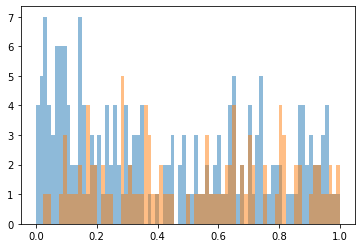

In [30]:
bins = np.linspace(0, 1, 80)
plt.hist(pT, bins=bins,alpha=0.5)
plt.hist(pT_pred, bins=bins,alpha=0.5)

(array([142., 133., 111.,  95.,  51.,  51.,  36.,  40.,  34.,  26.,  34.,
         26.,  23.,  29.,  29.,  35.,  22.,  26.,  29.,  22.,  28.,  31.,
         27.,  23.,  25.,  27.,  32.,  34.,  28.,  25.,  17.,  37.,  27.,
         41.,  20.,  37.,  24.,  22.,  26.,  25.,  29.,  27.,  31.,  20.,
         34.,  28.,  32.,  34.,  29.,  30.,  30.,  20.,  23.,  21.,  36.,
         26.,  35.,  33.,  32.,  24.,  33.,  27.,  30.,  38.,  24.,  32.,
         32.,  24.,  21.,  32.,  28.,  29.,  39.,  39.,  36.,  41.,  37.,
         34.,  27.]),
 array([0.        , 0.01265823, 0.02531646, 0.03797468, 0.05063291,
        0.06329114, 0.07594937, 0.08860759, 0.10126582, 0.11392405,
        0.12658228, 0.13924051, 0.15189873, 0.16455696, 0.17721519,
        0.18987342, 0.20253165, 0.21518987, 0.2278481 , 0.24050633,
        0.25316456, 0.26582278, 0.27848101, 0.29113924, 0.30379747,
        0.3164557 , 0.32911392, 0.34177215, 0.35443038, 0.36708861,
        0.37974684, 0.39240506, 0.40506329, 0.417721

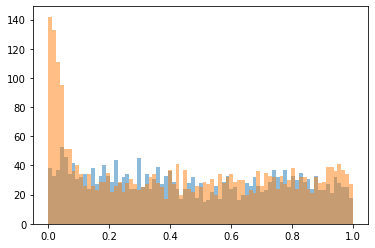

In [31]:
plt.hist(eta, bins=bins,alpha=0.5)
plt.hist(eta_pred, bins=bins,alpha=0.5)

(array([29., 24., 32., 34., 24., 29., 28., 44., 36., 33., 35., 36., 31.,
        38., 24., 34., 27., 28., 33., 28., 42., 26., 33., 32., 27., 24.,
        33., 39., 32., 28., 33., 33., 33., 36., 30., 37., 38., 38., 20.,
        39., 26., 37., 27., 26., 30., 27., 28., 40., 22., 23., 25., 32.,
        33., 38., 42., 41., 55., 68., 63., 55., 48., 47., 53., 50., 64.,
        54., 49., 52., 40., 41., 37., 39., 40., 53., 36., 47., 43., 33.,
        50.]),
 array([0.        , 0.01265823, 0.02531646, 0.03797468, 0.05063291,
        0.06329114, 0.07594937, 0.08860759, 0.10126582, 0.11392405,
        0.12658228, 0.13924051, 0.15189873, 0.16455696, 0.17721519,
        0.18987342, 0.20253165, 0.21518987, 0.2278481 , 0.24050633,
        0.25316456, 0.26582278, 0.27848101, 0.29113924, 0.30379747,
        0.3164557 , 0.32911392, 0.34177215, 0.35443038, 0.36708861,
        0.37974684, 0.39240506, 0.40506329, 0.41772152, 0.43037975,
        0.44303797, 0.4556962 , 0.46835443, 0.48101266, 0.49367089,
   

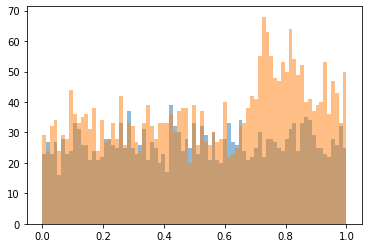

In [32]:
plt.hist(phi, bins=bins,alpha=0.5)
plt.hist(phi_pred, bins=bins,alpha=0.5)

(array([ 7.,  4.,  3.,  8.,  2.,  4.,  3.,  1.,  5.,  4.,  1.,  4.,  3.,
         7.,  3.,  5.,  5.,  9.,  2.,  2.,  4.,  5.,  7.,  4.,  3.,  4.,
         3.,  5.,  2.,  7.,  5.,  1.,  7.,  4.,  6.,  4.,  7.,  5.,  4.,
         6.,  6.,  2.,  6., 14., 11., 11., 11., 15., 18., 11.,  7., 12.,
        16.,  9., 12., 12., 14., 10.,  8.,  8., 14., 11., 14.,  9., 11.,
        11., 13.,  8.,  7.,  8.,  1.,  3.,  6.,  6.,  4.,  3.,  6.,  5.,
         6.]),
 array([0.        , 0.01265823, 0.02531646, 0.03797468, 0.05063291,
        0.06329114, 0.07594937, 0.08860759, 0.10126582, 0.11392405,
        0.12658228, 0.13924051, 0.15189873, 0.16455696, 0.17721519,
        0.18987342, 0.20253165, 0.21518987, 0.2278481 , 0.24050633,
        0.25316456, 0.26582278, 0.27848101, 0.29113924, 0.30379747,
        0.3164557 , 0.32911392, 0.34177215, 0.35443038, 0.36708861,
        0.37974684, 0.39240506, 0.40506329, 0.41772152, 0.43037975,
        0.44303797, 0.4556962 , 0.46835443, 0.48101266, 0.49367089,
   

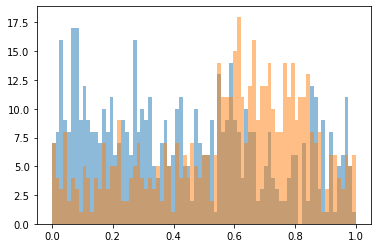

In [33]:
plt.hist(mass, bins=bins,alpha=0.5)
plt.hist(mass_pred, bins=bins,alpha=0.5)

In [34]:
d_pT = [row[0] for row in distr]
d_eta = [row[1] for row in distr]
d_phi = [row[2] for row in distr]
d_mass = [row[3] for row in distr]

## Distribution of (input - output) / input

In [35]:
bins = np.linspace(-1, 1, 30)

(array([  11.,   20.,   16.,   15.,   10.,   17.,   19.,   24.,   33.,
          44.,   52.,   93.,  151.,  323.,  992., 2444., 1650.,  452.,
         236.,  130.,   69.,   40.,   22.,   22.,   16.,   11.,    8.,
           8.,    7.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

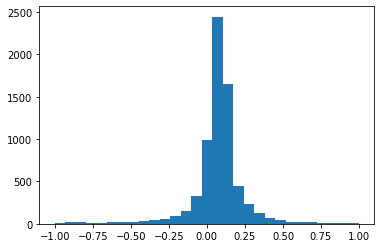

In [36]:
plt.hist(d_pT, bins=bins)

(array([ 30.,  36.,  40.,  41.,  50.,  53.,  79.,  54.,  71., 101., 131.,
        117., 127., 151., 202., 232., 234., 359., 405., 423., 319., 294.,
        280., 202., 205., 185., 192., 222., 242.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

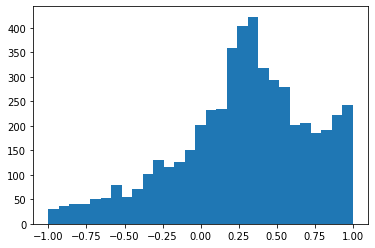

In [37]:
plt.hist(d_eta, bins=bins)

(array([ 27.,  38.,  44.,  54.,  53.,  56.,  67.,  62.,  68.,  73., 104.,
        123., 165., 149., 217., 238., 293., 384., 495., 450., 401., 361.,
        266., 214., 233., 170., 149., 154., 110.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

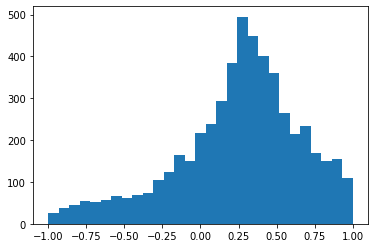

In [38]:
plt.hist(d_phi, bins=bins)